# Political Statements Reliability Analysis
Naman Nagelia
Emily Cheng


# Introduction
# 
In today's fast-paced information age, distinguishing between true and false statements has become more challenging than ever. With the rise of social media and digital news platforms, information spreads at an unprecedented rate, making it difficult to verify credibility. Misinformation can shape public opinion, influence elections, and even impact policy decisions.

To address this challenge, we leverage Natural Language Processing (NLP) to analyze and classify statements based on their truthfulness. Using machine learning models, we aim to identify patterns in language, source credibility, and contextual indicators that differentiate true statements from false, half-true, mostly-true, and barely-true claims.

Our dataset consists of fact-checked statements made by public figures, politicians, and media sources, each labeled with a truthfulness category. By training our model on these labeled statements, we aim to develop an automated classification system that can predict the accuracy of new statements.

Throughout this project, we will explore:

Text preprocessing techniques (tokenization, stopword removal, stemming)

Feature extraction

Machine learning models (logistic regression, decision trees, neural networks)

Evaluation metrics (accuracy, precision, recall, F1-score)

While our model will not be perfect, it will serve as a foundation for improving automated fact-checking—a crucial tool in combating misinformation in the digital world.


# Data Curation


We have 2 datasets from this website which we will use to help determine whether or not a political statement made by an individual with given qualities is likely to be reliable or false. The two datasets have different features and the purpose of this data curation section is to standardize them for consistency,




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### First Dataset
##### Source: PolitiFact
The first dataset is a tsv file with statements that vary in reliability. We'll read the tsv and turn it into a pandas dataframe, reformat some columns, and drop columns we don't need. 

Description: contains quotes with their truthfulness rating (e.g., True, Mostly True, Half True, Barely True, False, Pants on Fire). Also includes contextual information about the speaker like job title, the audience, the speaker's past statements and their political party.
#


In [3]:
statements = pd.read_csv('statements.tsv', sep='\t')
print(len(statements))
statements.head()

10239


,2635.json,false,Says the Annies List political group supports third-trimester abortions on demand.,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0.1,0.2,0.3,a mailer
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece


Since the dataset doesnt have headers, we set headers based on the description given on the politifact website. The dataset has missing values, represented by NaN, and so we changed all instances of NaN to 0's. 
#
Then, we dropped columns that are irrelevant for our analysis, including state, job title, and id. We also converted the count columns to integers here. 

In [4]:
statements = pd.read_csv('statements.tsv', sep='\t', header=None)
statements.columns = ["id", "reliability", "statement", "subject", "speaker", "job_title", "state", "party", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts", "audience"]
count_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements[count_columns] = statements[count_columns].fillna(0).astype(int)
statements.drop(columns = ["state", "job_title", "id"], inplace = True)
display(statements.head())

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,health-care,blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


The dataset's "subject" column was formatted as a string, often made up of multiple subjects, so we reformatted the column to be a list of subjects so it will be easier to categorize.

In [5]:
statements['subject'].unique()
statements['subject'] = statements['subject'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
statements['subject'] = statements['subject'].apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else x)
statements.head()


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne-bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott-surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack-obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog-posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie-crist,democrat,15,9,20,19,2,an interview on CNN


We now changed the format of speaker so that the first and last name are separated by a space instead of '-' for better readability and to match the format of speaker in the other dataseet.

In [6]:
statements['speaker'] = statements['speaker'].astype(str).str.lower().str.replace('-', ' ')
statements.head()

,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN


In the dataset, each statement is classified as one of the following: half true, mostly true, true, false, pants fire, or barely true. We want to sort all the statements so that they're classified as either "true" or "false". So, we classified "half true", "mostly true", and "true" as true and then classified "false", "pants fire", and "barely true" as false. 

In [7]:
true = ['half_true', 'mostly_true', 'true']
false = ['false', 'pants_fire', 'barely_true']
statements['verdict'] = statements['reliability'].apply(lambda x: 'true' if x in true else 'false')
display(statements.head())


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0,1,0,0,0,a mailer,false
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0,0,1,1,0,a floor speech.,false
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70,71,160,163,9,Denver,false
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7,19,3,5,44,a news release,false
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15,9,20,19,2,an interview on CNN,false


### Second Dataset
##### Source: PolitiFact

Now we process the second politifact file, a json. We will read the json and turn it into a pandas dataframe, rename the columns to fit the conventions of the first dataframe, and drop the columns we dont need. The dataset is formatted differently and using the similar names from the first dataset and renaming features we can infer our missing values



Description: Contains political quotes with their truthfulness rating (e.g., True, Mostly True, Half True, False, Pants on Fire). Also includes contextual information about the speaker like who they are, the audience, the speaker's past statements and their political party.

In [8]:
statements2 = pd.read_json("politifact_factcheck_data.json", lines=True)
statements2.head()


,verdict,statement_originator,statement,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,Adriel Bettelheim,6/16/2008,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,Yacob Reyes,6/13/2022,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,Clay Wirestone,5/27/2016,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,Madison Czopek,2/5/2021,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,Linda Qiu,8/30/2015,https://www.politifact.com/factchecks/2015/aug...


We'll format all the columns just as we had done in the first dataset. Again, we'll separate speaker name by space, rename columns, and drop unneccessary columns. Then, we'll classify the true, false, barely true, half true, mostly true statements as either true or false. 

In [9]:
statements2['statement_originator'] = statements2['statement_originator'].astype(str).str.lower().str.replace('-', ' ')
statements2.rename(columns={'statement_originator': 'speaker', 'verdict': 'reliability', 'statement_source': 'audience'}, inplace=True)
statements2.drop(columns=["factchecker", "factcheck_date", "factcheck_analysis_link"], inplace=True)
statements2['verdict'] = statements2['reliability'].apply(lambda x: 'true' if x in true else 'false')
statements2.head()




,reliability,speaker,statement,statement_date,audience,verdict
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false


Now as you see, we're still missing many key elements from the first dataframe such as political party and their statement history. Using the names we can infer this, and we will determine the subject of the statement in the next step

In [10]:
speaker_to_party = statements[['speaker', 'party']].drop_duplicates().set_index('speaker')['party'].to_dict()
statements2['party'] = statements2['speaker'].map(speaker_to_party)

counts_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']
statements['total_counts'] = statements[counts_columns].sum(axis=1)
max_count_rows = statements.loc[statements.groupby('speaker')['total_counts'].idxmax(), ['speaker'] + counts_columns]
statements2 = statements2.merge(max_count_rows, on='speaker', how='left')
statements2.fillna(0, inplace=True)
statements2.drop_duplicates(inplace=True)
statements2.head()




,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0


Notice that in statements2, the reliability rating is one of teh following: 'pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true'
In the first dataframe, where the reliability rating is one of the following: 'pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'
The only difference between the two is that 'mostly-false' appears in statements2, while 'barely-true' appears in statements (the first df). Since these labels convey a similar meaning, we will replace all instances of 'mostly-false' with 'barely-true' in statements2 for consistency."

In [11]:
statements2['reliability'] = statements2['reliability'].replace('mostly-false', 'barely-true')


Now the final column that is missing which is crucial is the subject of the statement. Using keywords, we can infer the topics. In order to classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and text similarity matching using Natural Language Processing (NLP).

To classify each statement with relevant subjects, we employ a two-step approach that combines keyword-based inference and semantic similarity matching using Sentence-BERT (SBERT).

1. Keyword-Based Subject Inference
To infer the subject of a statement, we use a predefined keyword-to-subject mapping. This mapping consists of key topics (e.g., economy, health-care, foreign-policy) and associated keywords commonly found in statements related to those topics.

By scanning each statement for the presence of these keywords, we can automatically infer up to three relevant subjects even if the statement does not explicitly mention the category.

Example Keyword-Based Classification:

A statement containing "inflation" or "GDP" is classified under "economy".

A statement mentioning "medicare" or "hospital" is linked to "health-care".

This method helps us efficiently label statements with topics even when there is no direct subject match in the dataset. However, keyword-based classification has limitations because it does not account for meaning and context.

2. Semantic Similarity-Based Subject Matching using SBERT
Since statements may cover complex or nuanced topics beyond simple keyword matching, we use SBERT embeddings and cosine similarity to match each statement to the most relevant subjects from our predefined topics.

Steps involved:
Convert all statements and subjects into SBERT embeddings – This captures the semantic meaning of both statements and policy topics. Bert considers context in the meaning of the word which is why we use it.

Compute cosine similarity between statement embeddings and subject embeddings – This measures how close a statement is to each policy category.

Identify the top three most similar subjects for each statement – The statement is assigned to the three closest subjects based on their vector representations.



In [12]:
all_topics = statements['subject'].explode().unique()
all_topics
#Looking at all the topics, i classified these manually
subject_map = {
    "abortion": ["abortion"],
    "energy": ["energy", "renewable", "oil", "gas", "coal", "gas-prices", "oil-spill"],
    "economy": ["economy", "inflation", "GDP", "market", "wealth", "deficit", "debt"],
    "jobs": ["jobs", "employment", "workforce", "hiring", "unions", "workers", "labor"],
    "health-care": ["health", "medicare", "insurance", "hospital", "medicaid", "public-health", "health-care"],
    "foreign-policy": ["war", "diplomacy", "treaty", "international", "iraq", "israel", "nuclear", "afghanistan", 'foreign-policy'],
    "elections": ["vote", "polls", "campaign", "ballot", "campaign-advertising", "redistricting", "elections"],
    "ethics": ["corruption", "ethics", "scandal", "fraud", "government-efficiency", "ethics"],
    "crime": ["crime", "criminal-justice", "law", "policing", "public-safety", "crime"],
    "climate-change": ["climate-change", "environment", "cap-and-trade", "climate-change"],
    "government-regulation": ["government-regulation", "market-regulation"],
    "technology": ["technology", "space", "science", "privacy"],
    "immigration": ["immigration", "border", "gays-and-lesbians"],
    "education": ["education", "schools", "teachers", "students"],
    "social-security": ["social-security", "pensions", "retirement"],
    "military": ["military", "veterans", "defense", "homeland-security"],
    "taxes": ["taxes", "financial-regulation", "bankruptcy", "stimulus"],
    "housing": ["housing", "real-estate"],
    "public-health": ["public-health", "disability", "drugs", "marijuana"],
    "transportation": ["transportation", "infrastructure"],
    "sports": ["sports", "baseball", "sports"],
    "religion": ["religion", "islam"],
    "food": ["food", "food-safety", "hunger", "nutrition"],
    "welfare": ["welfare", "poverty", "families"],
    "legal-issues": ["legal-issues", "supreme-court"],
    "public-service": ["public-service", "government-efficiency"],
}


In [13]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Load SBERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Get all subjects from the subject map
all_subjects = list(subject_map.keys())

# Encode the subjects
subject_embeddings = model.encode(all_subjects, convert_to_tensor=True)

# Encode the statements in statements2
statement_embeddings = model.encode(statements2["statement"].tolist(), convert_to_tensor=True)

# Compute cosine similarity between statements and subjects
similarity_matrix = cosine_similarity(statement_embeddings.cpu().numpy(), subject_embeddings.cpu().numpy())

# Get top 3 subjects for each statement
top_subjects = []
for i in range(len(statements2)):  # Iterate over rows (statements)
    similar_idx = similarity_matrix[i].argsort()[-3:][::-1]  # Top 3 subject indices for this statement
    subjects = [all_subjects[j] for j in similar_idx]  # Map indices back to subject names
    top_subjects.append(subjects)

statements2["subject"] = top_subjects
statements2.head()

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,reliability,speaker,statement,statement_date,audience,verdict,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,subject
0,true,barack obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,true,democrat,70.0,71.0,160.0,163.0,9.0,"[welfare, legal-issues, health-care]"
1,false,matt gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,false,republican,0.0,1.0,1.0,1.0,0.0,"[economy, welfare, immigration]"
2,mostly-true,kelly ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,false,republican,2.0,1.0,1.0,4.0,0.0,"[legal-issues, immigration, social-security]"
3,false,bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",2/1/2021,blog,false,0,0.0,0.0,0.0,0.0,0.0,"[public-health, crime, legal-issues]"
4,half-true,bobby jindal,"""I'm the only (Republican) candidate that has ...",8/30/2015,television,false,republican,0.0,1.0,4.0,4.0,0.0,"[elections, government-regulation, foreign-pol..."


# Exploratory Data Analysis

Now that our data is formatted properly, in this section of the data science life cycle, we are going to visualize the data in order to gain a better understanding of the data between our datasets. Lets first concat both of the DF into one main DF

In [14]:
print(statements.columns)

statements2.drop(columns=['statement_date'], inplace=True)
print(statements2.columns)

statements_main = pd.concat([statements, statements2], ignore_index=True)


Index(['reliability', 'statement', 'subject', 'speaker', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'audience', 'verdict',
       'total_counts'],
      dtype='object')
Index(['reliability', 'speaker', 'statement', 'audience', 'verdict', 'party',
       'barely_true_counts', 'false_counts', 'half_true_counts',
       'mostly_true_counts', 'pants_fire_counts', 'subject'],
      dtype='object')


Next, we'll take a look at the dataframe and its columns to figure out what we will explore in more detail.

In [15]:
print(statements.shape)
print(statements2.shape)
statements_main.shape
statements_main.head()

(10240, 13)
(21150, 12)


,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,none,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0


### Exploring Distribution of Reliability
Our first step is to analyze the distribution of reliability ratings in our dataset. We accomplish this by using box plots to visualize the count of each category: pants-fire, false, barely-true, half-true, mostly-true, and true. 
#
This allows us to observe how frequently each rating appears, identify any imbalances in the dataset, and gain insights into the overall reliability trends. Understanding this distribution is crucial for ensuring that our model is trained on a well-represented set of labels and can make meaningful predictions.

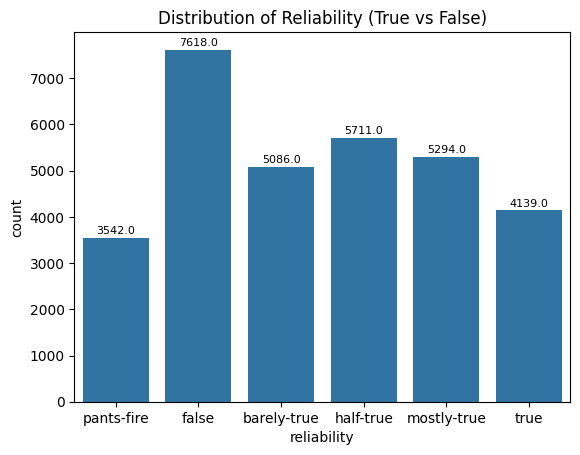

In [16]:

reliability_order = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']
ax = sns.countplot(data=statements_main, x='reliability', order=reliability_order)

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(
        f'{p.get_height()}', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center',  
        va='center', 
        fontsize=8, 
        xytext=(0, 5),  
        textcoords='offset points' 
    )

plt.title('Distribution of Reliability (True vs False)')
plt.show()

Some observations from the plot: 
- The "pants-fire" category, which represents the most extreme form of falsehood and lying, has fewer instances compared to regular "false" statements.
- The "false" category has the highest count, indicating that a significant portion of the statements in the dataset are classified as outright false.
- The counts for "barely-true," "half-true," and "mostly-true" are fairly similar, suggesting a somewhat balanced representation of statements with varying degrees of truthfulness.
- Similarly, the "true" category has the lowest count among the truth-based labels, indicating that fewer statements in the dataset are considered entirely true.

Overall, the dataset has a fairly even distribution of reliability counts, with most categories containing between 4,000 to 5,000 statements. The outliers are the "pants-fire" and "false" categories. Despite these outliers, the diversity in the data should help us create a well-trained and robust model.

However, false statements (pants-fire, false, barely-true) appear more frequently than true statements (half-true, mostly-true, true). Specifically, about 18,600 statements are false, compared to 12,767 true statements. This means approximately 60% of the dataset consists of false statements, which could impact the model's performance. The model may have a tendency to predict "false" more frequently than "true." This is something we'll consider as we build the model, and we may make adjustments if necessary.
# 


### Exploring Political Affiliation
Since such a large proportion of fake news comes from politicians and people in politics, we thought it would be interesting to investigate the relationship between political affiliation and statement reliability. Our dataset has many different parties so we'll first categorize them as democrat, republican, independent, media, or other. 

In [17]:
# Democrat, republican, independent (moderates, )

statements_main.party.value_counts()
statements_main['party'] = statements_main['party'].replace({
    "organization": 'media', 
    'newsmaker': 'media', 
    'journalist': 'media', 
    'columnist': 'media', 
    'talk-show-host': 'media',
    'none': 'independent', 
    'Moderate': 'independent', 
    0: 'independent', 
    "moderate": "independent"
})

# Replace specified parties with 'other'
statements_main['party'] = statements_main['party'].replace({
    'libertarian': 'other',
    'activist': 'other',
    'state-official': 'other',
    'labor-leader': 'other',
    'tea-party-member': 'other',
    'business-leader': 'other',
    'green': 'other',
    'education-official': 'other',
    'liberal-party-canada': 'other',
    'government-body': 'other',
    'democratic-farmer-labor': 'other',
    'ocean-state-tea-party-action': 'other',
    'constitution-party': 'other'
})

statements_main['party'].value_counts()


party
independent    11269
republican     11193
democrat        7877
media            734
other            315
Name: count, dtype: int64

Now, we'll perform a chi-squared test of independence to determine if there's a significant relationship between political affiliation and the reliability of the statements they make. In addition, we'll generate a heatmap to visualize the distribution of "false" and "true" statements across our 5 different political groups. 

In [18]:
from scipy.stats import chi2_contingency

display(statements_main.head())
true = ['half_true', 'mostly_true', 'true']
false = ['false', 'pants_fire', 'barely_true']

statements_main['Fake'] = statements_main['reliability'].apply(lambda x: 1 if x == 'false' else 0)
contingency_table = pd.crosstab(statements_main['party'], statements_main['Fake'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared statistic : {chi2}")
print(f"P-value : {p_value}")
print(f"Degrees of Freedom : {dof}")
print(f"Expected Frequencies:\n{expected}")



,reliability,statement,subject,speaker,party,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,audience,verdict,total_counts
0,false,Says the Annies List political group supports ...,[abortion],dwayne bohac,republican,0.0,1.0,0.0,0.0,0.0,a mailer,false,1.0
1,half-true,When did the decline of coal start? It started...,"[energy, history, job-accomplishments]",scott surovell,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,false,2.0
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",[foreign-policy],barack obama,democrat,70.0,71.0,160.0,163.0,9.0,Denver,false,473.0
3,false,Health care reform legislation is likely to ma...,[health-care],blog posting,independent,7.0,19.0,3.0,5.0,44.0,a news release,false,78.0
4,half-true,The economic turnaround started at the end of ...,"[economy, jobs]",charlie crist,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,false,65.0


Chi-squared statistic : 840.8600857987697
P-value : 1.0821260073373268e-180
Degrees of Freedom : 4
Expected Frequencies:
[[5965.72078501 1911.27921499]
 [8534.68421053 2734.31578947]
 [ 555.90187333  178.09812667]
 [ 238.56824264   76.43175736]
 [8477.12488849 2715.87511151]]


In our hypothesis test, our null hypothesis is that there is no relationship between political party and reliability. Our alternative hypothesis is that there is a relationship between political party and reliability. 

Chi-squared Statistic: The calculated Chi-squared statistic is 840.86, which is very large. A higher Chi-squared value indicates a significant deviation from the expected frequencies, suggesting that there is a strong association between the party and the reliability of statements.

P-value: The p-value is extremely small (1.08e-180), much smaller than the conventional threshold of 0.05 (95% confidence interval), indicating that the result is statistically significant. This means we can reject the null hypothesis (which assumes no relationship) and conclude that there is an association between a person's political party and the likelihood that their statements are classified as "false"

The Chi-squared test results suggest a strong relationship between political party affiliation and the reliability of statements made by individuals, with the p-value being extremely small. This means that the political party a person belongs to significantly influences whether their statements are perceived as "fake" or not. From our own experience witnissing fake news, this is not surprising and this is the result we expected to see. The heatmap visualization below further illustrates this relationship, allowing us to see how each party’s statements are distributed across the "false" and "true" categories.



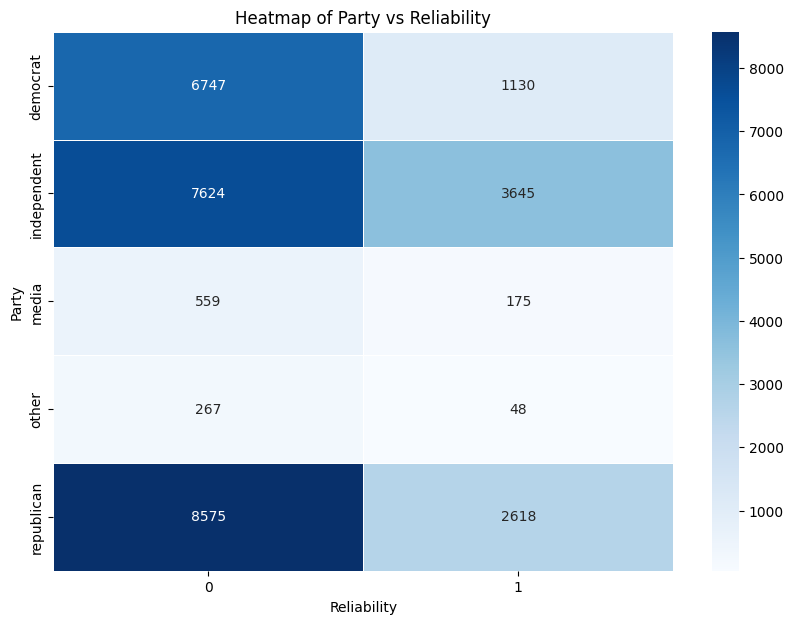

In [19]:
plt.figure(figsize=(10, 7))
heatmap = sns.heatmap(contingency_table, annot=True, fmt="d", cmap="Blues", cbar=True, linewidths=0.5)
plt.title('Heatmap of Party vs Reliability')
plt.xlabel('Reliability')
plt.ylabel('Party')
plt.show()

### Exploring Relationship Between Past Truthfulness and Statement Reliability
For our last exploration, we will see if there is any correalation between a politician's past statements as evidenced by their past truthfulness counts, and then their statements reliability to see if there is correalated. To do this, we'll use pearson coefficient and a heatmap to visualize this relationship.

The reliability column (made up of pants-fire, false, barely-true, half-true, mostly-true, true) needs to be numeric for us to use a pearson coefficient so we'll do a mapping to number 0-5 with 0 being pants-fire and 5 being true.

/var/folders/dv/8r8942l51v104x9yl5sywbtm0000gn/T/ipykernel_72052/3021659947.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['reliability_numeric'] = filtered_data['reliability'].map(reliability_map)


,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts,reliability_numeric
barely_true_counts,1.000000,0.924372,0.883864,0.836856,0.498139,-0.004207
false_counts,0.924372,1.000000,0.703503,0.635060,0.690804,-0.081336
half_true_counts,0.883864,0.703503,1.000000,0.985842,0.230402,0.092036
mostly_true_counts,0.836856,0.635060,0.985842,1.000000,0.150134,0.116273
pants_fire_counts,0.498139,0.690804,0.230402,0.150134,1.000000,-0.289079
reliability_numeric,-0.004207,-0.081336,0.092036,0.116273,-0.289079,1.000000


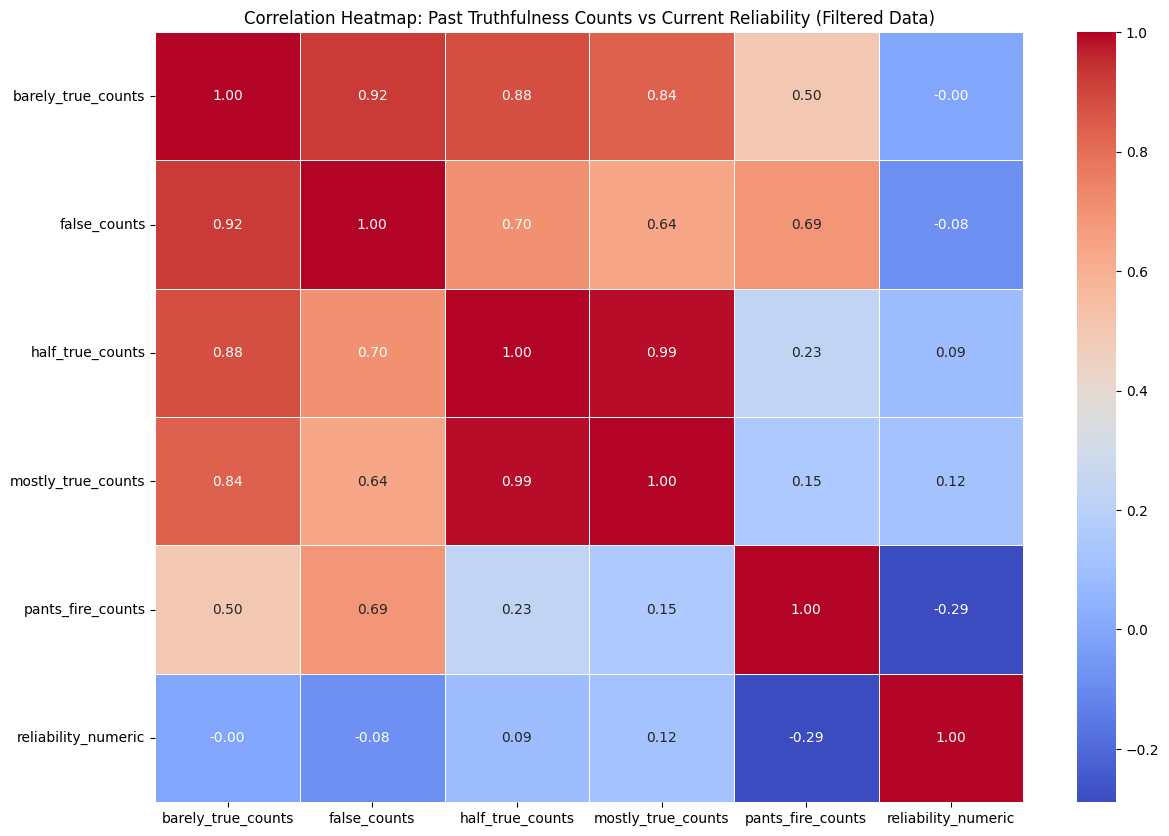

In [20]:
past_truthfulness_columns = ['barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_fire_counts']

# We only want to include statements that have data on the speaker's past truthfulness
# If there is no data on past reliability, don't include in this analysis
filtered_data = statements_main[statements_main[past_truthfulness_columns].sum(axis=1) > 0]

# Map the current reliability column to numeric values for correlation calculation
reliability_map = {
    'mostly-true': 4,
    'pants-fire': 0,
    'false': 1,
    'true': 5,
    'half-true': 3,
    'barely-true': 2
}

filtered_data['reliability_numeric'] = filtered_data['reliability'].map(reliability_map)

correlation_matrix = filtered_data[past_truthfulness_columns + ['reliability_numeric']].corr(method='pearson')

display(correlation_matrix)

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap: Past Truthfulness Counts vs Current Reliability (Filtered Data)")
plt.show()

Focusing first on past truthfulness counts correlation:
- Barely_true_counts has the highest correlation with other categories, with 0.924 for false_counts, 0.884 for half_true_counts, and 0.837 for mostly_true_counts. This suggests that when a speaker has a history of making statements that are "barely true," these are strongly associated with past counts in varying truthfullness levels which are not fully true or fully false. 

- False_counts has strong correlations with barely_true_counts (0.924) and pants_fire_counts (0.691), which indicates that speakers who frequently make fully false statements also tend to make statements that have varying degrees of falsehood.

- Half_true_counts and mostly_true_counts are very strongly correlated with each other (0.986), suggesting that when a speaker tends to tell "half-true" statements, they also tend to make "mostly-true" statements.

Now, looking at the correlation with reliability_numeric (which represents the current statement's reliability)
- barely_true_counts: There is a very weak correlation (0.003) with reliability_numeric. This indicates that a higher count of barely true statements in the past doesn't seem to significantly affect the reliability of the current statement.

- false_counts: The correlation is -0.077, which is very weak and indicates a very slight negative relationship. In other words, having more past false statements does not strongly correlate with the current statement being reliable or not.

- half_true_counts: The correlation is 0.11, suggesting a slight positive but weak relationship with the current statement's reliability.  This means that a speaker who has often made "half true" statements in the past might slightly be more likely to produce a reliable statement.

- mostly_true_counts: The correlation is 0.134, indicating a very weak positive correlation. This suggests that a speaker who has often made "mostly true" statements in the past might slightly be more likely to produce a reliable statement.

- pants_fire_counts: The correlation is -0.257, indicating a moderate negative correlation. This suggests that speakers who have made more "pants fire" statements in the past are more likely to have a less reliable current statement.

Now, we'll also visualize the relationship between past truthfulness and current statement's validity (using either true or false values). We've classified true, mostly true, and half true as true statements and barely true, false, and pants fire as false statements. 

In [23]:
import pandas as pd
politician_verdicts = statements_main.groupby(["speaker", "verdict"]).size().unstack(fill_value=0)
truthfulness_agg = statements_main.groupby("speaker")[["barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]].mean().astype(int)
politician_verdicts = politician_verdicts.merge(truthfulness_agg, left_index=True, right_index=True, how="left")

expected_categories = ["true", "false", "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_fire_counts"]
for category in expected_categories:
    if category not in politician_verdicts.columns:
        politician_verdicts[category] = 0

politician_verdicts.reset_index(inplace=True)
politician_verdicts.head()




,speaker,false,true,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_fire_counts
0,"""watch the water""",1,0,0,0,0,0,0
1,10 gop louisiana lawmakers,1,0,0,0,0,0,0
2,13th district gop slate,1,0,0,0,0,0,0
3,18 percent american public,1,1,0,0,0,0,1
4,18% of the american public,1,0,0,0,0,0,0


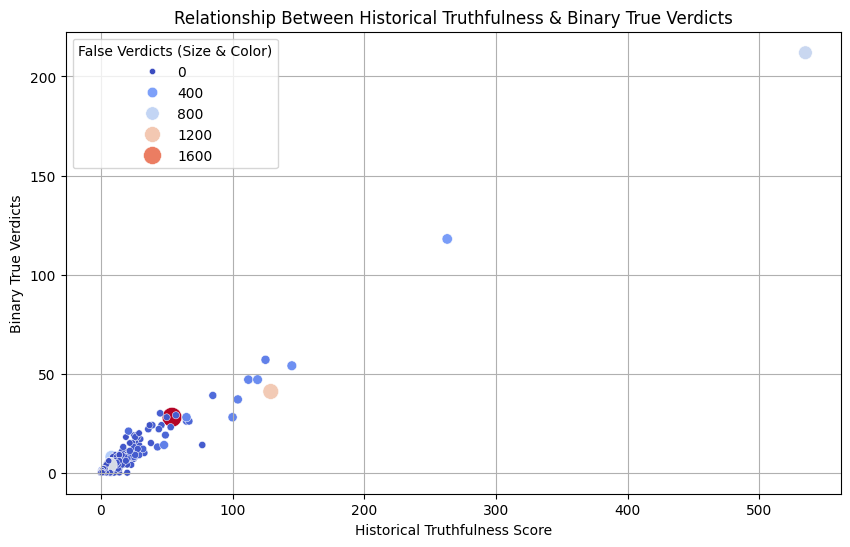

In [25]:
politician_verdicts["historical_truthfulness"] = (
    politician_verdicts["true"] + 
    politician_verdicts["half_true_counts"] + 
    politician_verdicts["mostly_true_counts"]
)

politician_verdicts["historical_falsehood"] = (
    politician_verdicts["false"] + 
    politician_verdicts["barely_true_counts"] + 
    politician_verdicts["pants_fire_counts"]
)

# Creating scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="historical_truthfulness", 
    y="true", 
    size="false", 
    hue="false", 
    data=politician_verdicts, 
    sizes=(20, 200), 
    palette="coolwarm"
)

plt.title("Relationship Between Historical Truthfulness & Binary True Verdicts")
plt.xlabel("Historical Truthfulness Score")
plt.ylabel("Binary True Verdicts")
plt.legend(title="False Verdicts (Size & Color)")
plt.grid(True)
plt.show()


From the scatterplot, we can see that the there is a general upward trend, suggesting that as a person's historical truthfulness score increases, the number of true verdicts they receive also increases.This indicates that individuals with a history of truthful statements tend to continue making more truthful statements.

The size and color of the points represent the count of false verdicts. Larger and more reddish points indicate individuals with higher counts of false statements.

Most points appear smaller and blue, meaning that a majority of individuals have relatively fewer false verdicts. Some points with high false verdicts (larger, reddish) are concentrated in the lower-left region, suggesting that individuals with a low historical truthfulness score tend to have more false statements. There are a few outliers, namely the large dark red dog who has a mix of both true and false verdicts.

# Conclusion
Our ultimate goal is to build a model which can use the language used in statements, along with relevant contextual information, to accurately predict a statement's reliability.

Overall, our two datasets offer a diverse range of data, with over 31,000 observations to analyze. Since false verdicts slightly outnumber true verdicts, our model may exhibit some bias toward predicting false statements, which we will account for during development. The key features we will focus on include historical truthfulness and political affiliation to assess how they influence the reliability of a speaker's statements. 








